# Goal

* Run `phylosignal::phyloSignal` on alpha diversity metric values

# Var

In [1]:
work_dir = '/ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT/'

# phyloseq
physeq_file = '/ebio/abt3_projects/Georg_animal_feces/data/16S/LLA/phyloseq/physeq_r5k.RDS'

# host phylogeny
host_tree_SpecD_file = '/ebio/abt3_projects/Georg_animal_feces/data/animal/phylogeny/TT/unified_metadata_complete_20180625_rn_16S-r5k_SpecD.nwk'

# alpha-div calculated with qiime2
alpha_div_file = "/ebio/abt3_projects/Georg_animal_feces/data/16S/LLA/diversity//alpha_div.RDS"

# params
threads = 12

# Init

In [2]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(ape)
library(phyloseq)
library(phylosignal)
library(doParallel)
#library(phytools)
source('/ebio/abt3_projects/Georg_animal_feces/code/init.R') 
source('/ebio/abt3_projects/Georg_animal_feces/code/itol.R') 


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: foreach
Loading required package: iterators
Loading required package: parallel


In [3]:
make_dir(work_dir)
setwd(work_dir)

Directory already exists: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT/ 


# Load

In [4]:
# phyloseq obj.
physeq = readRDS(physeq_file)
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 30290 taxa and 213 samples ]
sample_data() Sample Data:       [ 213 samples by 171 sample variables ]
tax_table()   Taxonomy Table:    [ 30290 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 30290 tips and 29752 internal nodes ]

In [5]:
# metadata
metadata = physeq %>% 
    sample_data %>% 
    as.matrix %>% 
    as.data.frame %>%
    mutate(scientific_name = gsub(' ', '_', scientific_name))

metadata %>% status

Warning message in class(X) <- NULL:
“Setting class(x) to NULL;   result will no longer be an S4 object”

[1] 213 171


X.SampleID,BarcodeSequence,LinkerPrimerSequence,Primer,ReversePrimer,Barcode_ID,sample_number,host_subject_id,host_german_name,host_common_name,⋯,wellplate_position_Illumina,Cornell_Dilution_DNA_Illumina,Num_Illumina,Num,sorting_454,comments_additional,DNA_box_20180622,sample_vol_20180622,sample_label_20180622,Description
X1.Eurasian.Beaver,ACTCACGGTATG,CATGCTGCCTCCCGTAGGAGT,GCCTCCCTCGCGCCATCAG,AGAGTTTGATCCTGGCTCAG,338R_BC0049,1,1,Biber,Eurasian.Beaver,⋯,B12,4,120,18,18,NA,1,20,1,NA
X101.Horse,ACGACGTCTTAG,CATGCTGCCTCCCGTAGGAGT,GCCTCCCTCGCGCCATCAG,AGAGTTTGATCCTGGCTCAG,338R_BC0030,101,101,Hauspferd,Horse,⋯,E8,16,344,160,160,NA,2,20,101,NA
X102.Kulan,ACGAGTGCTATC,CATGCTGCCTCCCGTAGGAGT,GCCTCCCTCGCGCCATCAG,AGAGTTTGATCCTGGCTCAG,338R_BC0031,102,102,Khulan,Kulan,⋯,E9,16,345,161,161,NA,2,20,102,NA


In [6]:
# host phylogeny
host_tree = read.tree(host_tree_SpecD_file)
host_tree


Phylogenetic tree with 128 tips and 127 internal nodes.

Tip labels:
	Sander_lucioperca, Esox_lucius, Salvelinus_fontinalis, Aspius_aspius, Leuciscus_idus, Blicca_bjoerkna, ...
Node labels:
	, @_22_@, @_8_@, @_7_@, @_20_@, @_17_@, ...

Rooted; includes branch lengths.

In [8]:
# load alpha-div values
alpha_div = readRDS(alpha_div_file)
alpha_div = do.call(cbind, alpha_div)
alpha_div$X.SampleID = rownames(alpha_div) 

alpha_div = alpha_div %>%
    gather(index, index_value, -X.SampleID)

alpha_div %>% status

[1] 852   3


X.SampleID,index,index_value
X1.Eurasian.Beaver,pielou_e,0.6507254
X101.Horse,pielou_e,0.9042161
X102.Kulan,pielou_e,0.8443325


# Mapping alpha div to host tree

## Shannon

In [9]:
# formatting for itol
alpha_div_s = metadata %>%
    dplyr::select(X.SampleID, scientific_name) %>%
    inner_join(alpha_div, c('X.SampleID')) %>%
    filter(index == 'shannon') %>%
    group_by(scientific_name,  index) %>%
    summarize(
        minimum = min(index_value),
        q1 = quantile(index_value, 0.25),
        median = median(index_value),
        q3 = quantile(index_value, 0.75),
        maximum = max(index_value)
    ) %>%
    ungroup() %>% 
    dplyr::select(-index) %>%
    as.data.frame

rownames(alpha_div_s) = alpha_div_s$scientific_name
alpha_div_s$scientific_name = NULL

alpha_div_s %>% status

Warning message:
“Column `X.SampleID` joining factor and character vector, coercing into character vector”

[1] 128   5


,minimum,q1,median,q3,maximum
Acrocephalus_scirpaceus,3.606900,3.606900,3.606900,3.606900,3.606900
Aepyceros_melampus,5.495224,5.495224,5.495224,5.495224,5.495224
Anas_platyrhynchos,3.608049,3.608049,3.608049,3.608049,3.608049


In [10]:
# writing itol boxplot
out_file = file.path(work_dir, 'shannon_itol-boxplot.txt')
itol_boxplot(alpha_div_s, 'shannon_boxplot', out_file)

File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT//shannon_itol-boxplot.txt 


## Faith's PD

In [11]:
# formatting for itol
alpha_div_s = metadata %>%
    dplyr::select(X.SampleID, scientific_name) %>%
    inner_join(alpha_div, c('X.SampleID')) %>%
    filter(index == 'faith_pd') %>%
    group_by(scientific_name,  index) %>%
    summarize(
        minimum = min(index_value),
        q1 = quantile(index_value, 0.25),
        median = median(index_value),
        q3 = quantile(index_value, 0.75),
        maximum = max(index_value)
    ) %>%
    ungroup() %>%
    dplyr::select(-index) %>%
    as.data.frame

rownames(alpha_div_s) = alpha_div_s$scientific_name
alpha_div_s$scientific_name = NULL

alpha_div_s %>% status

Warning message:
“Column `X.SampleID` joining factor and character vector, coercing into character vector”

[1] 128   5


,minimum,q1,median,q3,maximum
Acrocephalus_scirpaceus,9.086015,9.086015,9.086015,9.086015,9.086015
Aepyceros_melampus,27.445870,27.445870,27.445870,27.445870,27.445870
Anas_platyrhynchos,9.912024,9.912024,9.912024,9.912024,9.912024


In [12]:
# itol boxplot
out_file = file.path(work_dir, 'faithPD_itol-boxplot.txt')
itol_boxplot(alpha_div_s, 'faithPD_boxplot', out_file)

File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT//faithPD_itol-boxplot.txt 


# Mean alpha div

## Formatting

In [13]:
# checking sample overlap
intersect(alpha_div$X.SampleID %>% unique, 
          metadata$X.SampleID %>% unique) %>% length %>% print

intersect(metadata$scientific_name %>% unique, 
          host_tree$tip.label) %>% length %>% print

[1] 213
[1] 128


In [14]:
# filtering metadata & summarizing by host
df = metadata %>%
    inner_join(alpha_div, c('X.SampleID')) %>%
    group_by(scientific_name,  index) %>%
    summarize(mean_alpha_div_value = mean(index_value)) %>%
    ungroup() %>%
    mutate(mean_alpha_div_value = mean_alpha_div_value %>% as.Num) %>%
    spread(index, mean_alpha_div_value) %>%
    filter(scientific_name %in% host_tree$tip.label) %>%
    as.data.frame

df$scientific_name %>% unique %>% length %>% print
df %>% status

Warning message:
“Column `X.SampleID` joining factor and character vector, coercing into character vector”

[1] 128
[1] 128   5


scientific_name,faith_pd,observed_otus,pielou_e,shannon
Acrocephalus_scirpaceus,9.086015,73,0.5827143,3.606900
Aepyceros_melampus,27.445870,405,0.6344222,5.495224
Anas_platyrhynchos,9.912024,85,0.5629316,3.608049


In [15]:
# writing table
tip_data_file = file.path(work_dir, 'tip-data_alpha-div.tsv')
write.table(df, tip_data_file, sep='\t', row.names=FALSE)
cat('File written: ', tip_data_file, '\n')

File written:  /ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT//tip-data_alpha-div.tsv 


## Regressing out diet

* Regressing out detailed diet info

In [17]:
.mean = function(x){
    x = gsub(' .+', '', x)
    stopifnot(x %in% c('yes', 'no'))
    x = ifelse(x=='yes', 1, 0)
    mean(as.numeric(x))
}

diet_detail = metadata %>%
    group_by(scientific_name) %>%
    summarize(
        diet_vertebrate = .mean(diet_vertebrate),
        diet_invertebrate = .mean(diet_invertebrate),
        diet_fruit = .mean(diet_fruit),
        diet_flowers_nectar_pollen = .mean(diet_flowers_nectar_pollen),
        diet_leaves_branches_bark_buds = .mean(diet_leaves_branches_bark_buds),
        diet_seeds = .mean(diet_seeds),
        diet_grass_waterplants = .mean(diet_grass_waterplants),
        diet_roots_tubers = .mean(diet_roots_tubers)
    ) %>%
    ungroup()

diet_detail %>% status

[1] 128   9


scientific_name,diet_vertebrate,diet_invertebrate,diet_fruit,diet_flowers_nectar_pollen,diet_leaves_branches_bark_buds,diet_seeds,diet_grass_waterplants,diet_roots_tubers
Acrocephalus_scirpaceus,0,1,1,0,0,1,0,0
Aepyceros_melampus,0,0,0,1,1,1,1,0
Anas_platyrhynchos,0,1,0,0,1,1,1,0


In [18]:
# joining
df_j = df %>%
    inner_join(diet_detail, c('scientific_name')) 

df_j %>% status

[1] 128  13


scientific_name,faith_pd,observed_otus,pielou_e,shannon,diet_vertebrate,diet_invertebrate,diet_fruit,diet_flowers_nectar_pollen,diet_leaves_branches_bark_buds,diet_seeds,diet_grass_waterplants,diet_roots_tubers
Acrocephalus_scirpaceus,9.086015,73,0.5827143,3.606900,0,1,1,0,0,1,0,0
Aepyceros_melampus,27.445870,405,0.6344222,5.495224,0,0,0,1,1,1,1,0
Anas_platyrhynchos,9.912024,85,0.5629316,3.608049,0,1,0,0,1,1,1,0


[1] 128   4


,faith_pd,shannon,observed_otus,pielou_e
Acrocephalus_scirpaceus,-0.1278358,-0.0630195,-0.1128694,-0.007470306
Aepyceros_melampus,-0.4400226,-0.6996897,-0.1321044,-0.851251057
Anas_platyrhynchos,-1.4000014,-0.9737452,-1.6272754,-0.626503702


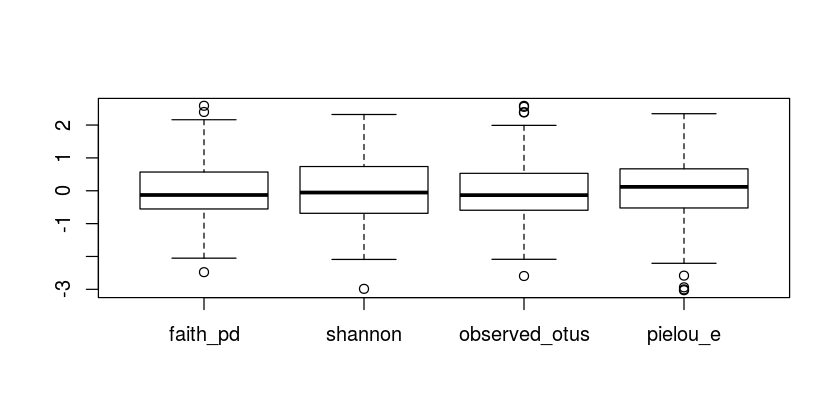

In [20]:
#' function to get residuals from linear regression
regress_out = function(y, covars, df){
    covars = paste(covars, collapse=' + ')
    f = paste(c(y, covars), collapse=' ~ ')
    f = as.formula(f)
    lm_res = lm(f, data=df)
    lm_res$residuals
}

# vars
covars = c('diet_vertebrate','diet_invertebrate','diet_fruit',
           'diet_flowers_nectar_pollen','diet_leaves_branches_bark_buds',
           'diet_seeds','diet_grass_waterplants','diet_roots_tubers')
indices = c('faith_pd', 'shannon', 'observed_otus', 'pielou_e')

# regression
df_j_f = lapply(as.list(indices), regress_out, covars=covars, df=df_j)

# formatting output
df_j_f = do.call(rbind, df_j_f) %>% t %>% as.data.frame
colnames(df_j_f) = indices
rownames(df_j_f) = df_j$scientific_name

# scaling
df_j_f = scale(df_j_f) %>% as.data.frame

# status
options(repr.plot.height=3.5)
boxplot(df_j_f) 
df_j_f %>% status

In [21]:
# writing table
tip_data_file = file.path(work_dir, 'tip-data_alpha-div_diet-resid.tsv')
write.table(df_j_f, tip_data_file, sep='\t')
cat('File written: ', tip_data_file, '\n')

File written:  /ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT//tip-data_alpha-div_diet-resid.tsv 


## itol plotting of residuals

In [22]:
out_file = file.path(work_dir, 'alpha-div_diet-residuals_itol-htmp.txt')
itol_heatmap(df_j_f[,c('faith_pd', 'shannon')], 'alpha-div_diet-resid', out_file)

Warning message in if (color_scheme == "color") {:
“the condition has length > 1 and only the first element will be used”Warning message in vegan::vegdist(., method = dist_method):
“results may be meaningless because data have negative entries in method “bray””

File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT//alpha-div_diet-residuals_itol-htmp.txt 


## phylogenetic signal

In [23]:
df = df_j_f
df %>% status

[1] 128   4


,faith_pd,shannon,observed_otus,pielou_e
Acrocephalus_scirpaceus,-0.1278358,-0.0630195,-0.1128694,-0.007470306
Aepyceros_melampus,-0.4400226,-0.6996897,-0.1321044,-0.851251057
Anas_platyrhynchos,-1.4000014,-0.9737452,-1.6272754,-0.626503702


In [24]:
# convert to phylo4d
host_tree_4d = phylobase::phylo4d(host_tree, tip.data=df)
host_tree_4d %>% summary

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'
Also defined by ‘RNeXML’


 Length   Class    Mode 
      1 phylo4d      S4 

In [25]:
# phylosignal calculation
physig_res = phyloSignal(host_tree_4d, methods = 'all', reps = 999)

In [26]:
# formatting results
tmp1 = physig_res$stat 
tmp1$OTU = rownames(tmp1)

tmp2 = physig_res$pvalue
tmp3 = apply(tmp2, 2, function(x) p.adjust(x, method='BH')) %>% as.data.frame
tmp2$OTU = rownames(tmp2)
tmp3$OTU = rownames(tmp2)

tmp1 = tmp1 %>%
    gather(method, coef, -OTU)
tmp2 = tmp2 %>%
    gather(method, pvalue, -OTU)
             
physig_res_j = tmp1 %>%
    inner_join(tmp2, c('OTU', 'method')) %>%
    rename('index' = OTU) %>%
    filter(index %in% c('faith_pd', 'shannon', 'observed_otus', 'pielou_e')) %>%
    mutate(qvalue = p.adjust(pvalue, method='BH'))  %>%
    mutate(significant = qvalue < 0.01)
             
tmp1 %>% nrow %>% print
physig_res_j %>% status

[1] 20
[1] 20  6


index,method,coef,pvalue,qvalue,significant
faith_pd,Cmean,0.2747333,0.001,0.003333333,TRUE
shannon,Cmean,0.1800614,0.003,0.006666667,TRUE
observed_otus,Cmean,0.2766151,0.001,0.003333333,TRUE


File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT/.figures/phyloSig_alpha-div_IndD.pdf 


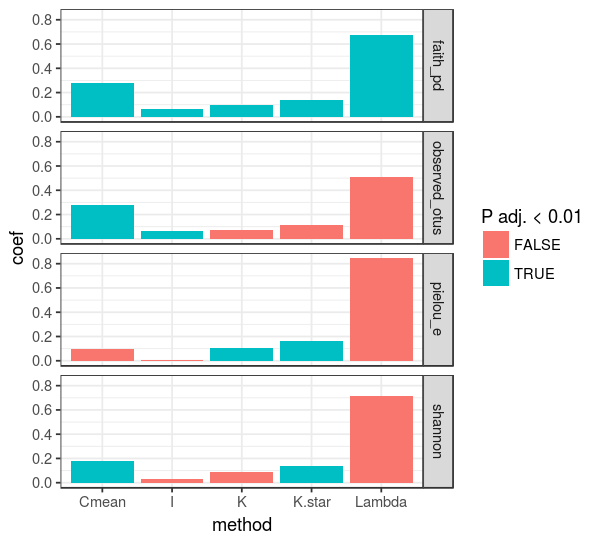

In [27]:
# plotting
p = ggplot(physig_res_j, aes(method, coef, fill=significant)) +
    geom_bar(stat='identity') +
    facet_grid(index ~ .) +
    scale_fill_discrete('P adj. < 0.01') +
    theme_bw() 

options(repr.plot.width=5, repr.plot.height=4.5)
plot_write(p, file='phyloSig_alpha-div_IndD.pdf')

#### Notes

* Abouheif‘s Cmean is the only measure to not use branch lengths
* Abouheif‘s Cmean & Moran's I measure autocorrelation; not an evolutionary model

## lipaMoran

In [28]:
# calculating lipaMoran for each trait
lipaMoran_per = function(trait, tree_4d, reps=999, ...){
    res = lipaMoran(tree_4d, trait=trait, reps = reps, prox.phylo = "nNodes", ...)
    z = colnames(res$lipa)[1]
    x = res$lipa
    colnames(x) = c('coef')
    y = res$p.value 
    colnames(y) = c('pvalue')
    df = cbind(x,y) %>% as.data.frame
    df$index = z
    df$host = rownames(df)
    rownames(df) = 1:nrow(df)
    return(df)
}

traits = physig_res_j$index %>% unique
traits %>% length

[1] 4

In [29]:
# calculating 
registerDoParallel(cores=threads)
lipa_res = plyr::llply(as.list(traits), lipaMoran_per, 
                       tree_4d=host_tree_4d, 
                       reps=9999, 
                       .parallel=TRUE)
lipa_res = do.call(rbind, lipa_res)
lipa_res %>% status

[1] 512   4


coef,pvalue,index,host
0.08735852,0.0519,faith_pd,Sander_lucioperca
0.10300190,0.0784,faith_pd,Esox_lucius
0.07078658,0.1257,faith_pd,Salvelinus_fontinalis


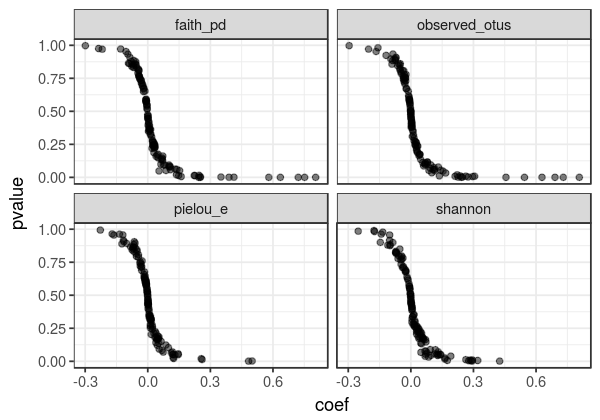

In [30]:
# plotting p-value ~ coef
p = ggplot(lipa_res, aes(coef, pvalue)) +
    geom_point(alpha=0.5) +
    facet_wrap(~ index) +
    theme_bw() 

options(repr.plot.width=5, repr.plot.height=3.5)
plot(p)

In [31]:
# p-value dist
lipa_res$qvalue = p.adjust(lipa_res$pvalue, method='BH')
lipa_res$qvalue %>% summary

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.004654 0.618637 0.783951 0.700889 0.939857 0.997200 

In [32]:
# q-value dist
lipa_res_f = lipa_res %>%
    filter(qvalue < 0.05) 

lipa_res_f %>% status

[1] 22  5


coef,pvalue,index,host,qvalue
0.3893489,3e-04,faith_pd,Anas_platyrhynchos,0.010971429
0.7212041,1e-04,faith_pd,Branta_leucopsis,0.004654545
0.6353730,1e-04,faith_pd,Anser_anser,0.004654545


In [33]:
# summary
lipa_res_f$index %>% table

.
     faith_pd observed_otus      pielou_e       shannon 
            9             9             2             2 

### Formatting for iTOL

In [34]:
if(nrow(lipa_res_f) > 0){
    lipa_res_f_s = lipa_res_f %>% 
        dplyr::select(index, host, coef) %>%
        spread(index, coef) %>%
        right_join(data.frame(tips = host_tree$tip.label), 
                    c('host'='tips')) 

    rownames(lipa_res_f_s) = lipa_res_f_s$host
    lipa_res_f_s$host = NULL

    lipa_res_f_s %>% summary %>% print
    lipa_res_f_s %>% status
}

Warning message:
“Column `host`/`tips` joining character vector and factor, coercing into character vector”

    faith_pd      observed_otus       pielou_e         shannon      
 Min.   :0.2444   Min.   :0.2272   Min.   :0.4830   Min.   :0.2944  
 1st Qu.:0.3893   1st Qu.:0.2467   1st Qu.:0.4873   1st Qu.:0.3272  
 Median :0.5801   Median :0.5444   Median :0.4917   Median :0.3599  
 Mean   :0.5323   Mean   :0.5081   Mean   :0.4917   Mean   :0.3599  
 3rd Qu.:0.7212   3rd Qu.:0.6907   3rd Qu.:0.4960   3rd Qu.:0.3927  
 Max.   :0.8045   Max.   :0.8073   Max.   :0.5003   Max.   :0.4255  
 NA's   :119      NA's   :119      NA's   :126      NA's   :126     
[1] 128   4


,faith_pd,observed_otus,pielou_e,shannon
Sander_lucioperca,NA,NA,NA,NA
Esox_lucius,NA,NA,NA,NA
Salvelinus_fontinalis,NA,NA,NA,NA


In [35]:
# adding missing indices
if(nrow(lipa_res_f) > 0){
    missing = setdiff(c('faith_pd', 'shannon', 'observed_otus', 'pielou_e'), colnames(lipa_res_f_s))
    for(m in missing){
        lipa_res_f_s[,m] = NA
    }
}

lipa_res_f_s %>% status

[1] 128   4


,faith_pd,observed_otus,pielou_e,shannon
Sander_lucioperca,NA,NA,NA,NA
Esox_lucius,NA,NA,NA,NA
Salvelinus_fontinalis,NA,NA,NA,NA


In [36]:
cols_to_keep = c('faith_pd', 'shannon')
lipa_res_f_s_f = lipa_res_f_s[,cols_to_keep]

if(nrow(lipa_res_f) > 0){
    itol_htmp_file = file.path(work_dir, 'lipaMoran_sig_htmp.txt')
    labs = gsub(' ', '_', colnames(lipa_res_f_s_f))
    labs = sprintf('FIELD_LABELS %s\n', paste(labs, collapse=' '))

    cat('DATASET_HEATMAP\n', file=itol_htmp_file)
    cat('SEPARATOR SPACE\n', file=itol_htmp_file, append=TRUE)
    cat('DATASET_LABEL alpha_div_lipaMoran\n', file=itol_htmp_file, append=TRUE)
    cat('COLOR #ff0000\n', file=itol_htmp_file, append=TRUE)
    cat(labs, file=itol_htmp_file, append=TRUE)

    #cat('FIELD_TREE ', file=itol_htmp_file, append=TRUE)
    #write.tree(clado, file=itol_htmp_file, append=TRUE)

    cat('DATA\n', file=itol_htmp_file, append=TRUE)
    write.table(lipa_res_f_s_f, file=itol_htmp_file, append=TRUE, sep=' ', 
                quote=FALSE, col.names=FALSE)

    cat('File written:', itol_htmp_file, '\n')
}

File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT//lipaMoran_sig_htmp.txt 


# sessionInfo

In [37]:
sessionInfo()

R version 3.4.1 (2017-06-30)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 16.04.4 LTS

Matrix products: default
BLAS: /ebio/abt3_projects/software/miniconda3/envs/py3_physeq_physig/lib/R/lib/libRblas.so
LAPACK: /ebio/abt3_projects/software/miniconda3/envs/py3_physeq_physig/lib/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] bindrcpp_0.2      doParallel_1.0.10 iterators_1.0.8   foreach_1.4.3    
 [5] phylosignal_1.2   phyloseq_1.22.3   ape_5.0           ggplot2_2.2.1    
 [9] tidyr_0.7.1       dplyr_0